<a href="https://colab.research.google.com/github/andythetechnerd03/PyTorch_Learning/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow

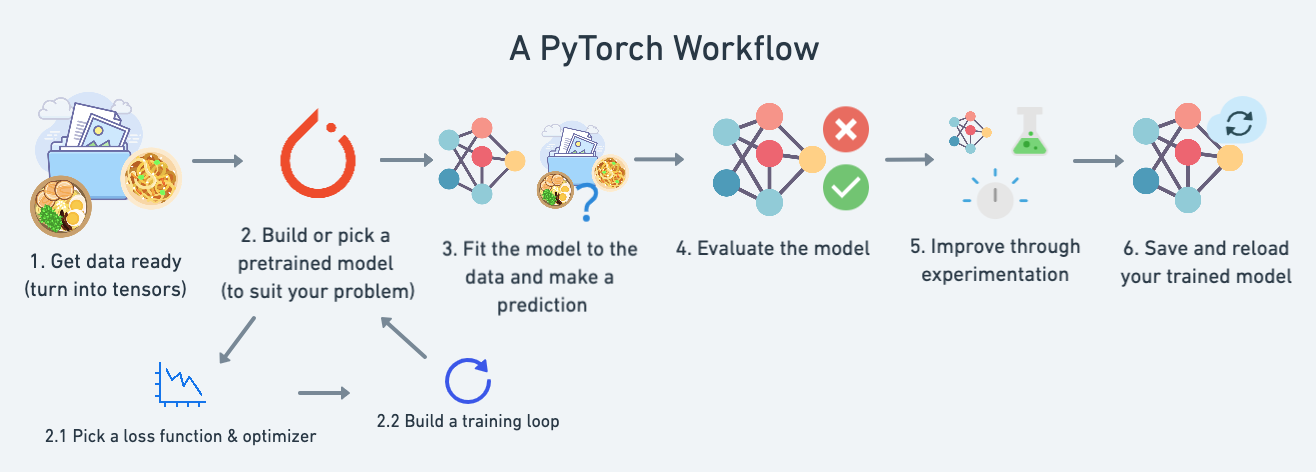

In [1]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

## 1. Data (preparing and loading)

We'll use linear regression to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

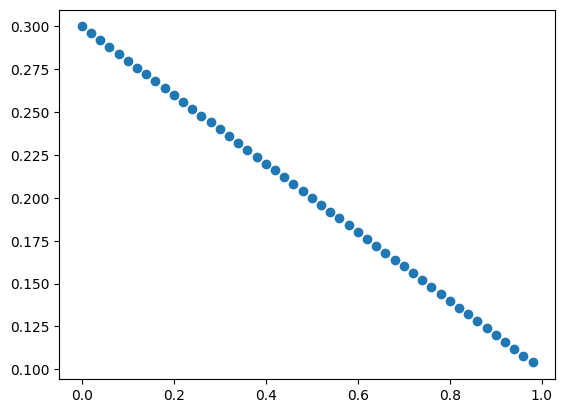

In [3]:
# create *known* parameters
weight = -0.2
bias = 0.3

# create data
start = 0
end = 1
step = 0.02
X = torch.arange(start,end, step) # features
y = weight * X + bias # labels

plt.scatter(X,y)

### Split data into training and test set

In [4]:
train_size = 0.8 # 80% of the data for training
train_split = int(train_size * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

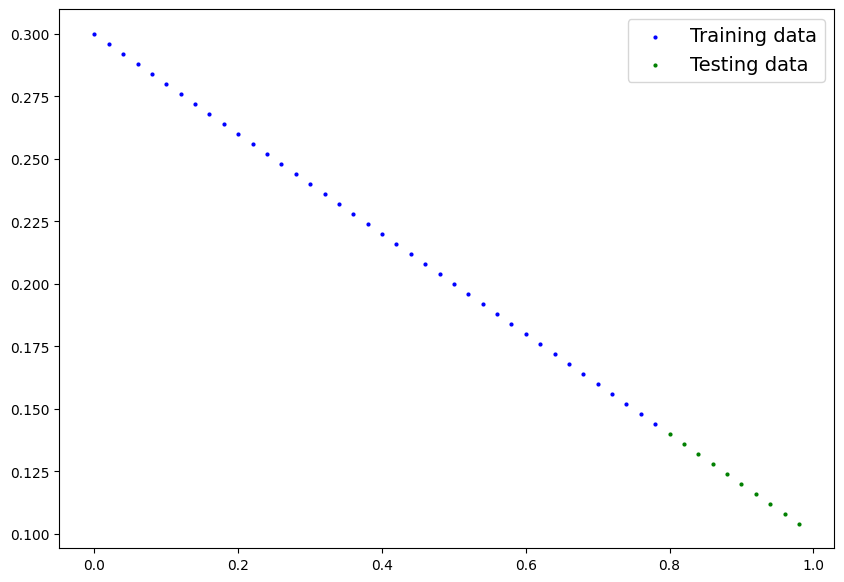

In [6]:
plot_predictions();

## 2. Build a model

In [7]:
class LinearRegression(nn.Module):
  def __init__ (self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, dtype=torch.float),
                                requires_grad=True) # gradient descent

    self.bias = nn.Parameter(torch.randn(1, dtype=torch.float),
                                requires_grad=True) # gradient descent

  def forward(self, x: torch.Tensor) -> torch.Tensor: # input x, output y
    return self.weights * x + self.bias # linear regression formula

### Checking the content of a PyTorch model

In [8]:
# set manual seed
torch.manual_seed(42)

# create an instance of the model
model_0 = LinearRegression()

# Check the parameters of the model using nn.Parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Make predictions using ```torch.inference_mode()```

Kinda like ```model.predict()``` in Tensorflow.

In [10]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

# Note: in older PyTorch, we use torch.no_grad() but inference_mode is faster
# with torch.no_grad():
#    y_preds = model_0(X_test)

```torch.inference_mode()``` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make **forward-passes** (data going through the ```forward()``` method) faster.

In [11]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([0.3982, 0.4049, 0.4116, 0.4184, 0.4251, 0.4318, 0.4386, 0.4453, 0.4520,
        0.4588])


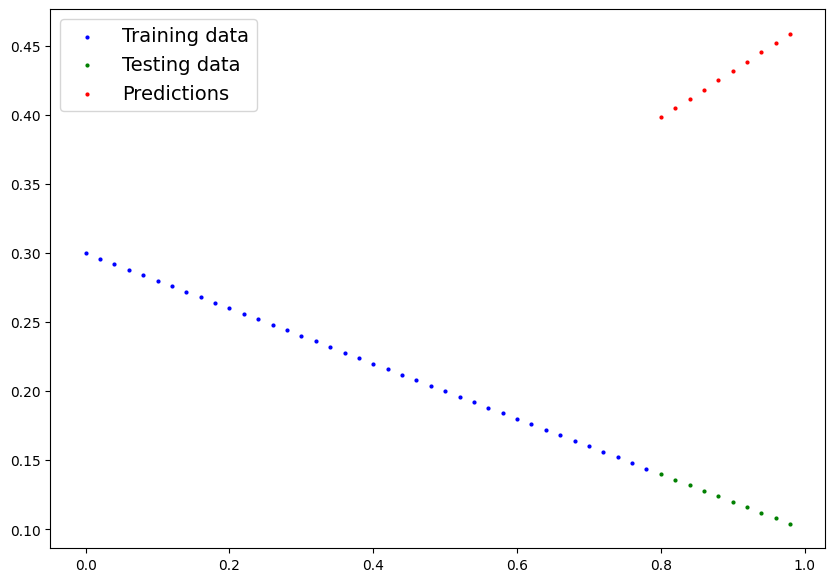

In [12]:
plot_predictions(predictions=y_preds)


## 3. Train model

Ctrl + MM: turn code cell to markdown cell \\
Ctrl + MY: turn markdown cell to code cell

### Loss function: difference between ground truth and model prediction
Use functions in ```torch.nn```. \\
Ex: MAE: ```torch.nn.L1Loss()```, Binary Cross Entropy ```torch.nn.BCELoss()``` \\
### Optimizer: how the parameters will be updated
Use ```torch.optim```.  
Ex: ```torch.optim.SGD()``` or ```torch.optim.Adam()```

In [13]:
# Create a loss function
loss_fn = nn.L1Loss() # MAE

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameter of the target model
                            lr=0.01) # learning rate

### Create a training loop and testing loop

The training loop involves the model going through the training data and learning the relationships between the ```features``` and ```labels```.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never see's the testing data during training).

Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.

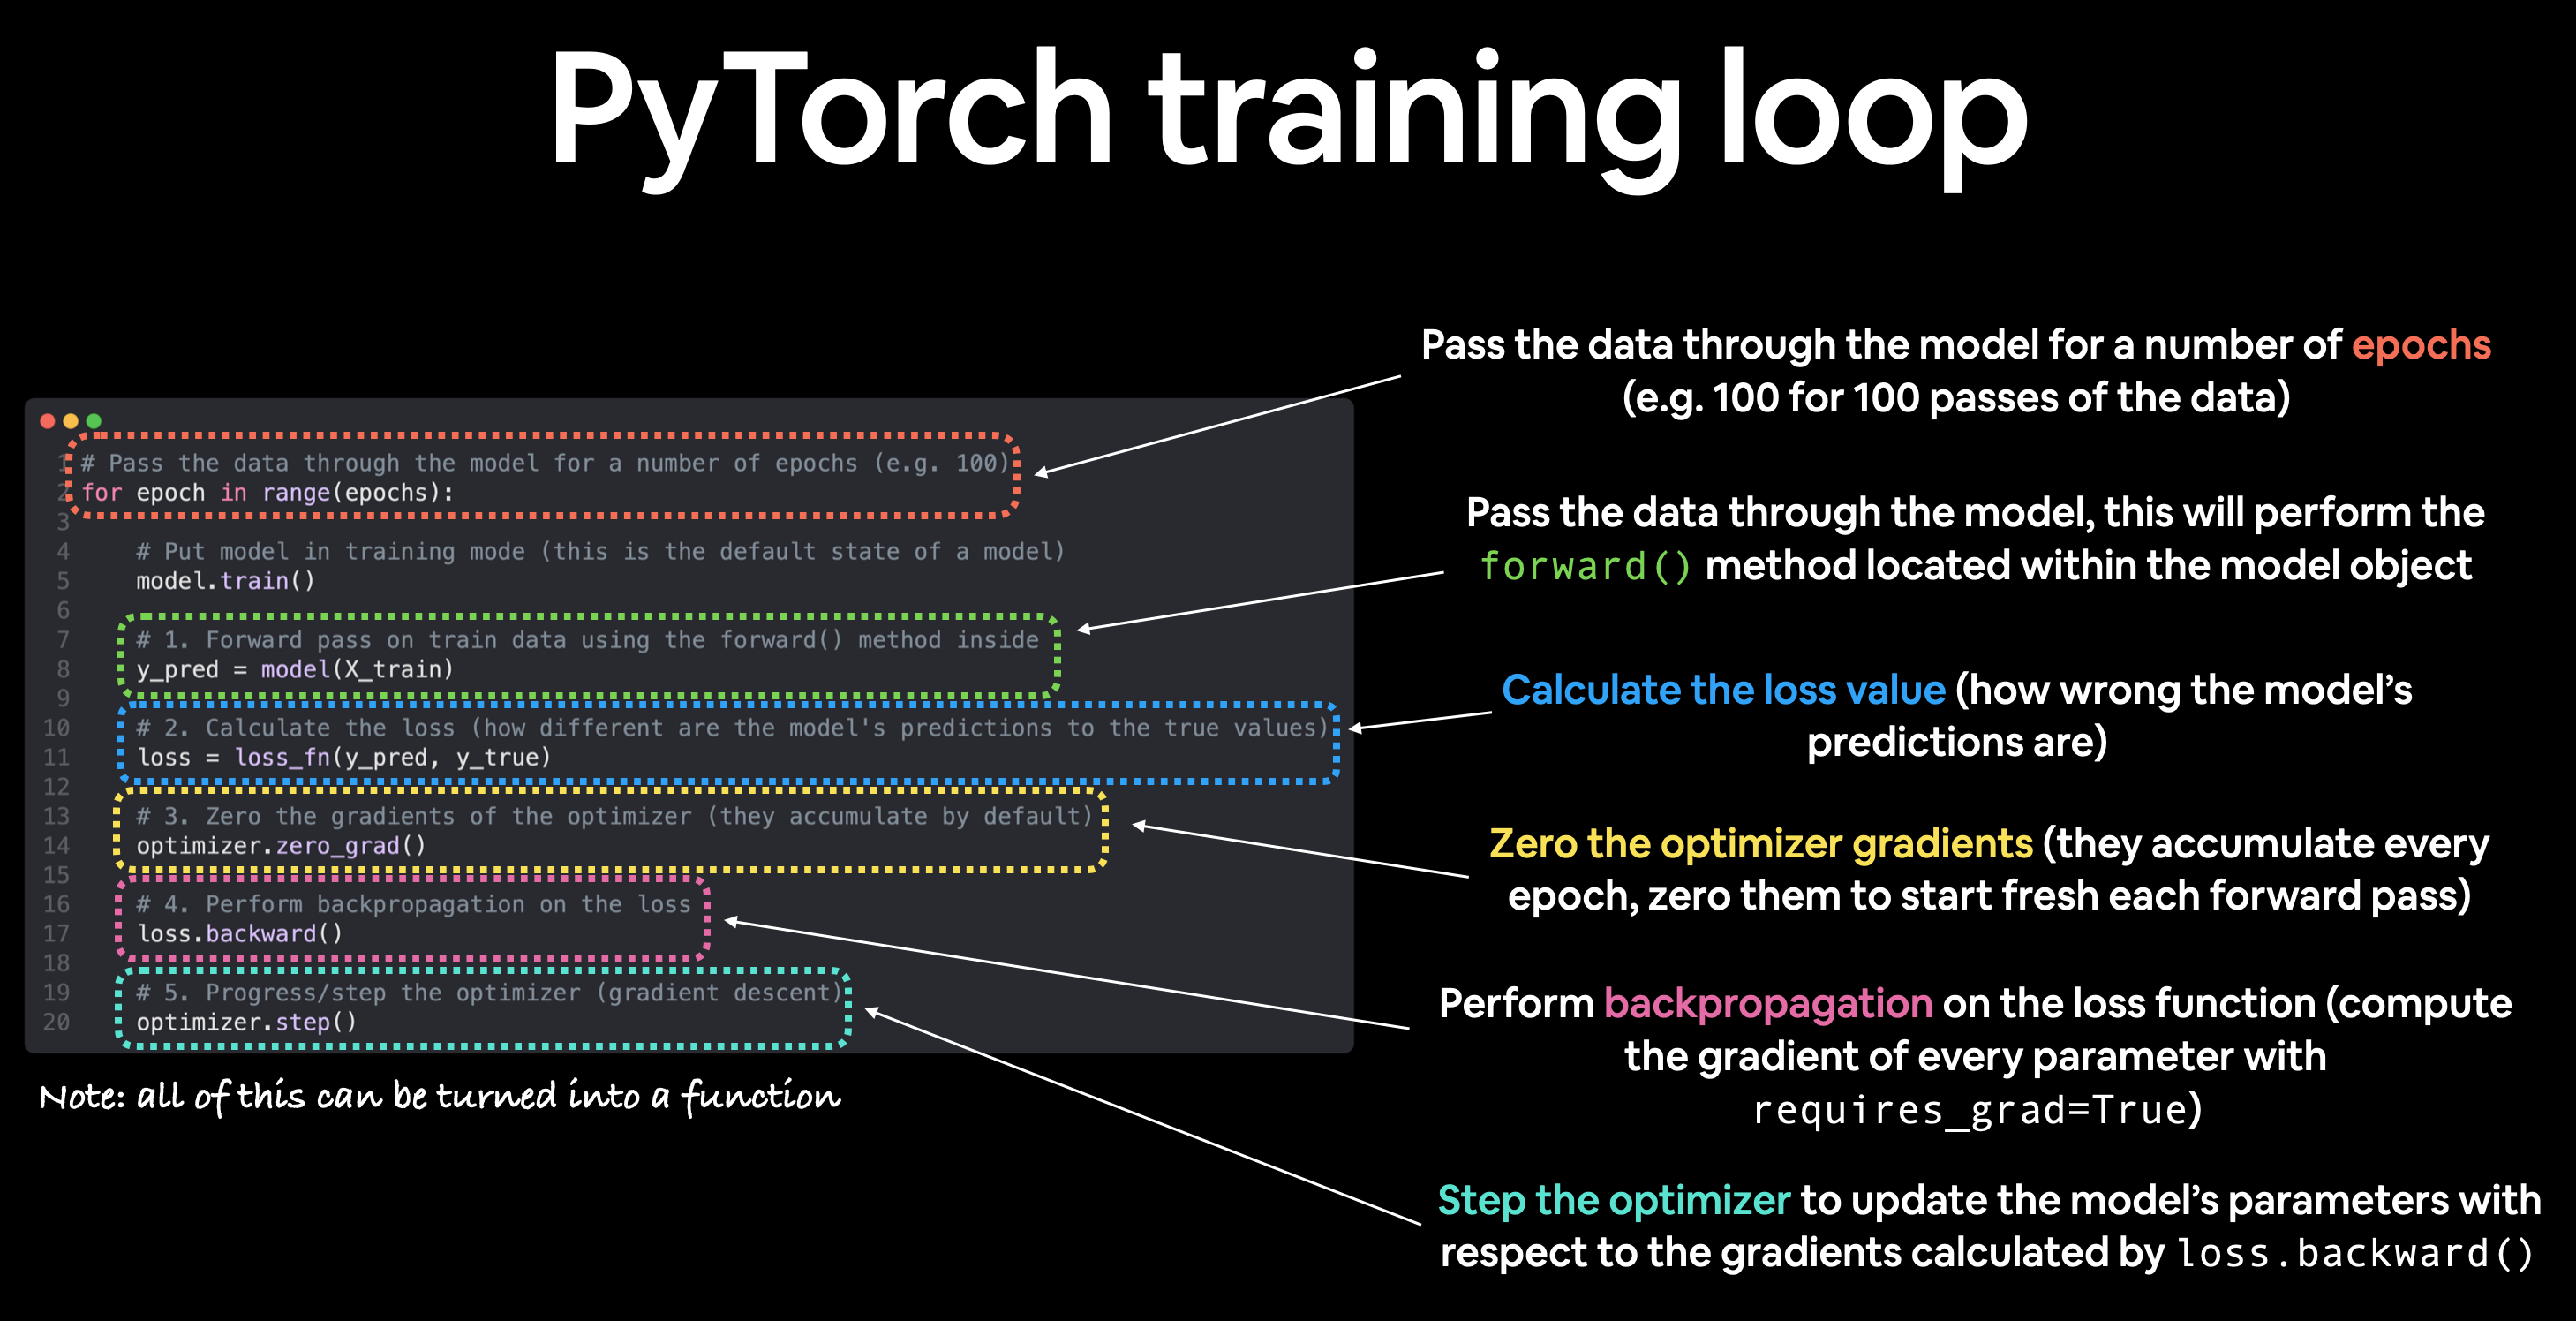

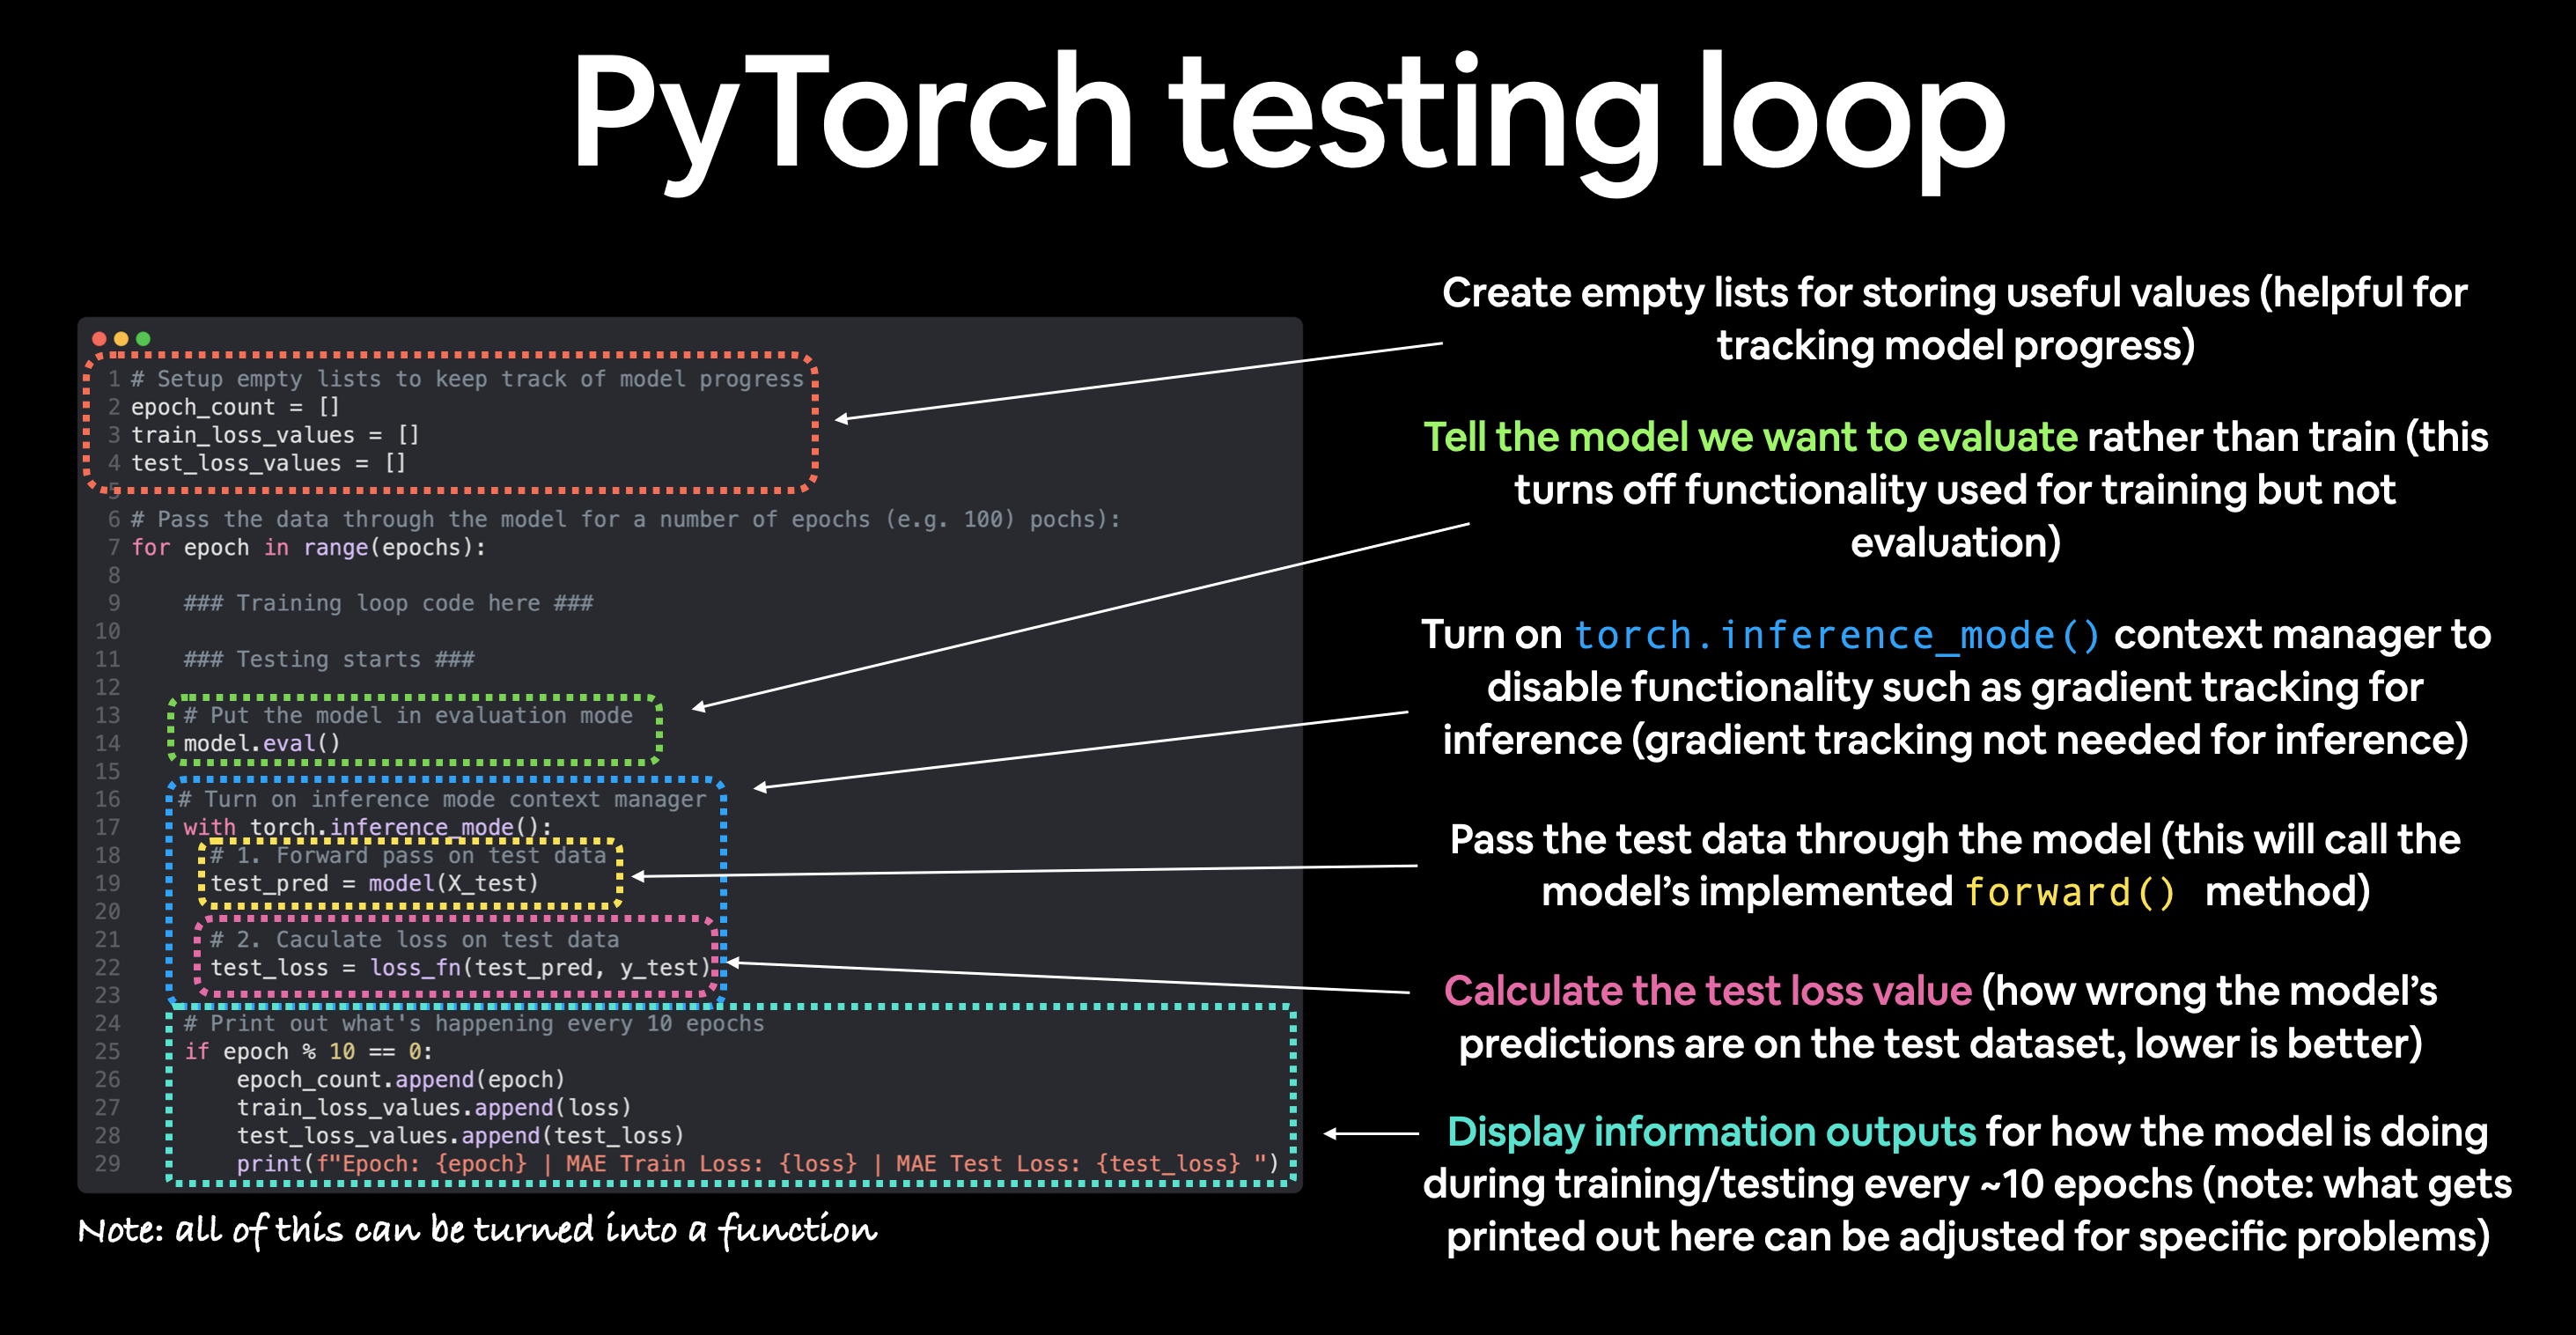

In [14]:
torch.manual_seed(42)

# Set the number of epochs: how mnay times the model will pass through the training data)
epochs = 1000

# Create empty lists
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
  ### Training

  # Put model in training mode
  model_0.train()

  # 1. Forward pass on training data using the forward() method inside
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Progress the optimizer
  optimizer.step()

  ### Testing

  # Put the model in evaluation mode
  model_0.eval()

  with torch.inference_mode():
    #1. Forward pass
    test_pred = model_0(X_test)

    #2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test.type(torch.float))

    # Print out what's happening
    if epoch % 100 == 0:
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | MAE Train loss: {loss} | MAE Test loss: {test_loss}")




Epoch: 0 | MAE Train loss: 0.11066827923059464 | MAE Test loss: 0.3020608127117157
Epoch: 100 | MAE Train loss: 0.06985980272293091 | MAE Test loss: 0.16260719299316406
Epoch: 200 | MAE Train loss: 0.035510219633579254 | MAE Test loss: 0.08194361627101898
Epoch: 300 | MAE Train loss: 0.002009705873206258 | MAE Test loss: 0.005110348574817181
Epoch: 400 | MAE Train loss: 0.004960442893207073 | MAE Test loss: 0.005110348574817181
Epoch: 500 | MAE Train loss: 0.004960442893207073 | MAE Test loss: 0.005110348574817181
Epoch: 600 | MAE Train loss: 0.004960442893207073 | MAE Test loss: 0.005110348574817181
Epoch: 700 | MAE Train loss: 0.004960442893207073 | MAE Test loss: 0.005110348574817181
Epoch: 800 | MAE Train loss: 0.004960442893207073 | MAE Test loss: 0.005110348574817181
Epoch: 900 | MAE Train loss: 0.004960442893207073 | MAE Test loss: 0.005110348574817181


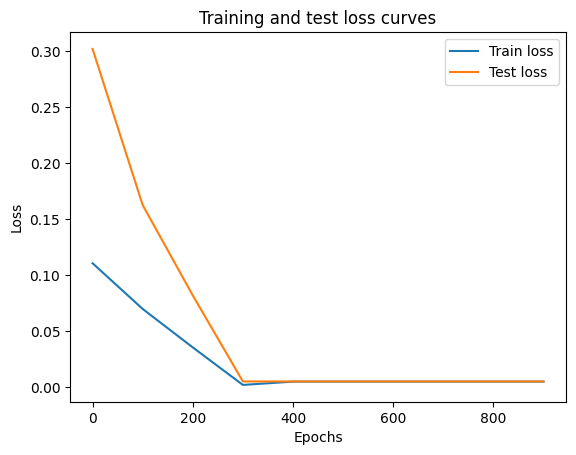

In [15]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [16]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([-0.1932])), ('bias', tensor([0.3023]))])

And the original values for weights and bias are:
weights: -0.2, bias: 0.3


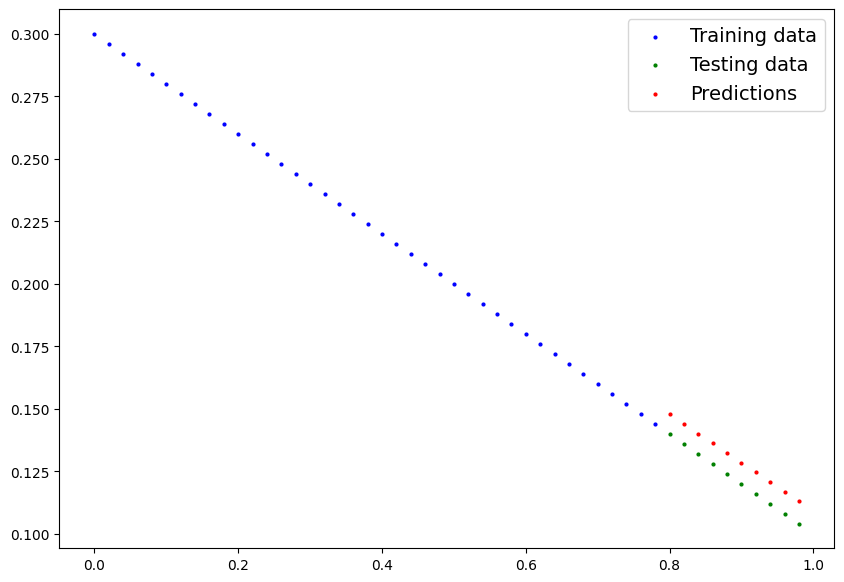

In [17]:
plot_predictions(predictions=model_0(X_test).detach().numpy())


# 4. Making predictions with a trained PyTorch model

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

- Set the model in evaluation mode (```model.eval()```).
- Make the predictions using the inference mode context manager (with ```torch.inference_mode(): ...```).
- All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

In [18]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([0.1477, 0.1439, 0.1400, 0.1362, 0.1323, 0.1284, 0.1246, 0.1207, 0.1168,
        0.1130])

## 5. Saving and loading a PyTorch model

```torch.save```:	Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using ```torch.save```.

```torch.load```:	Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).

```torch.nn.Module.load_state_dict```:	Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.

Use pickle as a format for storing the model

### Saving a PyTorch model's ```state_dict()```

The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's state_dict().

Let's see how we can do that in a few steps:

1. We'll create a directory for saving ```models``` to called models using Python's ```pathlib``` module.
2. We'll create a file path to save the model to.
3. We'll call ```torch.save(obj, f)``` where obj is the target model's ```state_dict()``` and ```f``` is the filename of where to save the model.

```Note:``` It's common convention for PyTorch saved models or objects to end with ```.pt``` or ```.pth```, like ```saved_model_01.pth```.

In [19]:
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to models/01_pytorch_workflow_model_0.pth


In [20]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1207 Jul  7 13:57 models/01_pytorch_workflow_model_0.pth


### Loading a saved PyTorch model's ```state_dict()```

Use ```torch.nn.load_state_dict(torch.load(f))```, which essentially is that we load the model's parameters instead of the whole model

Saving the entire model rather than just the state_dict() is more intuitive, however, to quote the PyTorch documentation (italics mine):

> The disadvantage of this approach (saving the whole model) is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...

> Because of this, your code can break in various ways when used in other projects or after refactors.

So instead, we're using the flexible method of saving and loading just the state_dict(), which again is basically a dictionary of model parameters.

In [21]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegression()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [22]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [23]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([True, True, True, True, True, True, True, True, True, True])

# 6. Putting all together

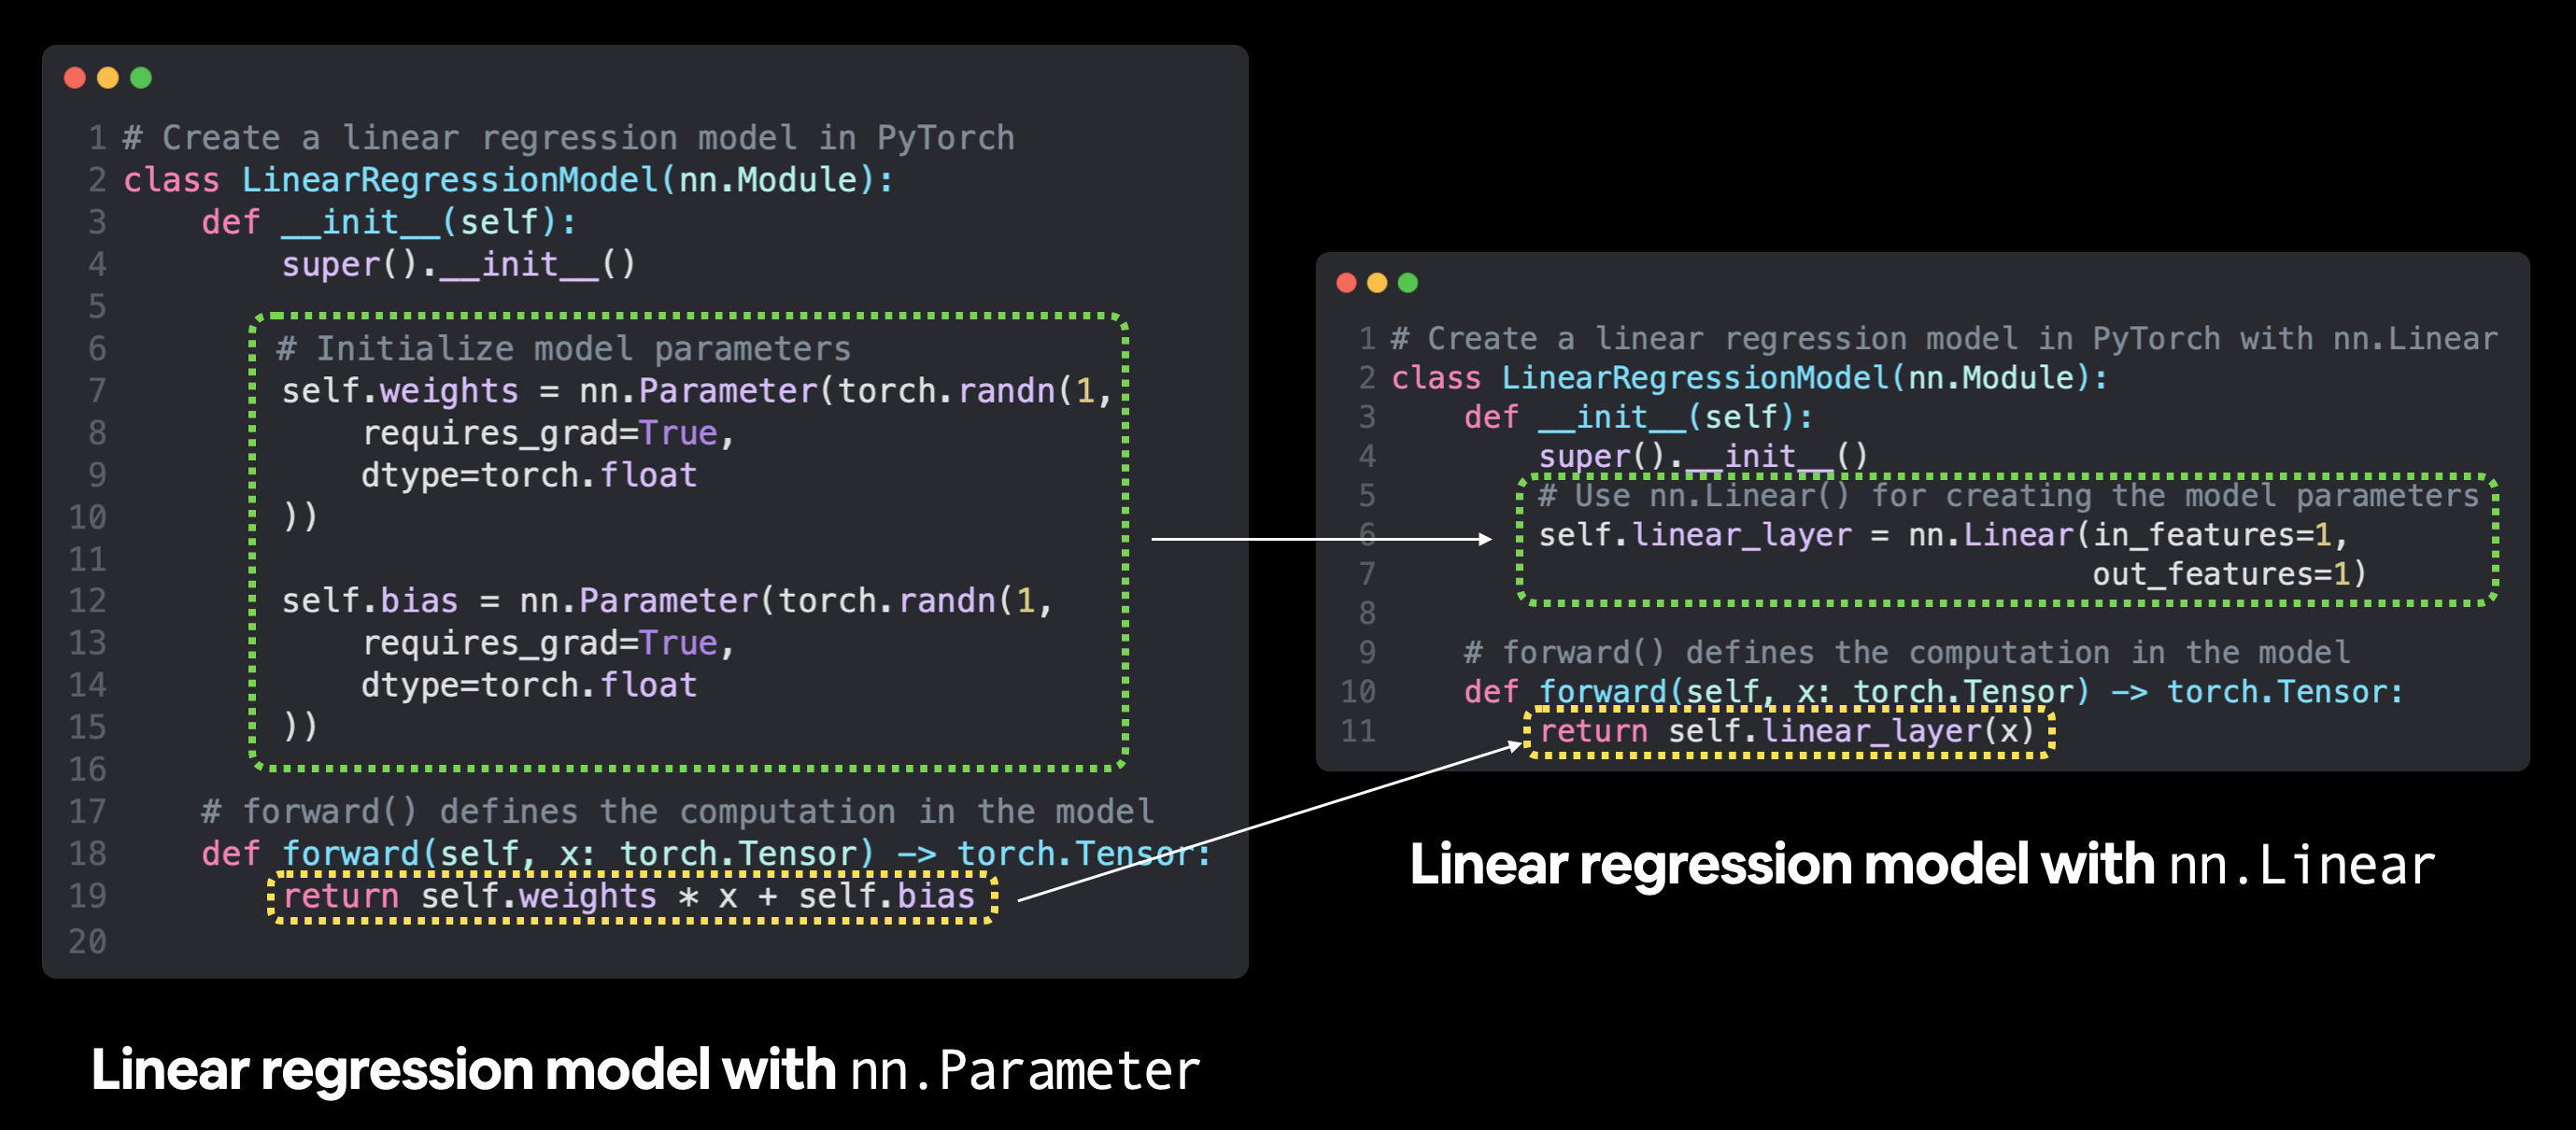

When using GPU, keep in mind:
- Move the model and all the data to the GPU
- Plot the loss and all that stuff then move all the data to the CPU

In [2]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

In [7]:
class LinearRegressionV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear for creating the model parameters
    self.linear_layer = nn.Linear(in_features = 1,
                                  out_features = 1)

  # Define the forward propagation
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionV2()
model_1, model_1.state_dict()

(LinearRegressionV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [8]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [9]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

In [10]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

In [11]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882


In [12]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [13]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

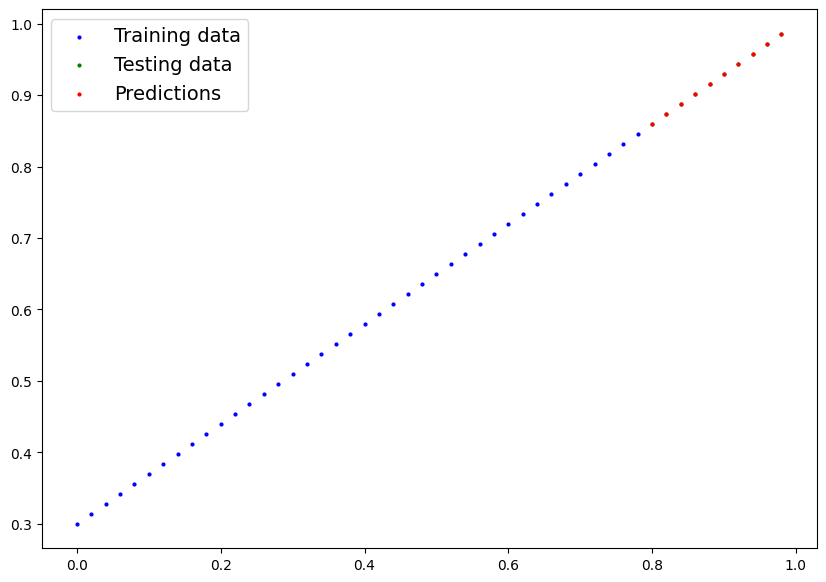

In [14]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

In [15]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [17]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [18]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')